In [140]:
#vårt projekt

from typing import Tuple

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR
import random
import numpy as np
import math

import matplotlib.pyplot as plt
from tqdm import tqdm
from torchtext.data.metrics import bleu_score

In [141]:
print(torch.__version__)

2.2.2


In [142]:
# pip install sentencepiece
# pip install tqdm
#conda install pytorch torchvision torchaudio -c pytorch
#python -m pip uninstall pytorch

In [143]:
import sentencepiece as spm

In [144]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [145]:
if torch.cuda.is_available():
    device = 'cuda'

else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE


device(type='cpu')

In [146]:
#Alice paths
# data_path = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.en'
# data_path_2 = '/Users/alicetottie/Downloads/projekt_data/train_paracrawl.sv'

#Maja paths
# data_path = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.en'
# data_path_2 = '/Users/majarygard/Documents/LTH/Projekt i Data/train_paracrawl.sv'

#Pernilla paths
#data_path = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.en\\train_paracrawl.en'
#data_path_2 = 'C:\\Users\\nilla\\Plugg\\project-data\\train_paracrawl.sv\\train_paracrawl.sv'


In [147]:
# with open(data_path, "r", encoding="utf-8") as f:
#     lines = f.read().split("\n")

# with open(data_path_2, "r", encoding="utf-8") as f:
#     lines2 = f.read().split("\n")    

In [148]:
data_path = 'swe.txt'

In [149]:
#len(lines)



In [150]:
#len(lines2)

In [151]:
# num_samples = 1000
# input_texts = []
# target_texts = []

# for line in lines[: min(num_samples, len(lines) - 1)]:
#     input_text= line.split("\t")
#     input_texts.append(input_text)

# with open("input_texts.txt", "w", encoding='utf-8') as f:
#     for input_text in input_texts:
#         f.write('\t'.join(input_text) + '\n')
    
# for line in lines2[: min(num_samples, len(lines2) - 1)]:
#     target_text= line.split("\t")
#     target_texts.append(target_text)  

# with open("input_texts.txt", "a", encoding='utf-8') as f:
#     for target_text in target_texts:
#         f.write('\t'.join(target_text) + '\n') 

In [152]:
num_samples = 5000
input_texts = []
target_texts = []

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.readlines()  # Read lines instead of using split("\n")

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.strip().split("\t")  # Strip to remove leading/trailing whitespaces
    input_texts.append([input_text])
    target_texts.append([target_text])

with open("all_texts.txt", "w", encoding='utf-8') as f:
    for input_text in input_texts:
        f.write(input_text[0] + '\n')  # Write the first element of input_text on a new line
    for target_text in target_texts:
        f.write(target_text[0] + '\n')  # Write the first element of target_text on a new line

In [153]:
input_texts[50]



['Get out!']

In [154]:
target_texts[50]

['Ut med er!']

In [155]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

4000

In [156]:
text_pairs = list(zip(input_texts, target_texts))
random.shuffle(text_pairs)
input_texts, target_texts = zip(*text_pairs)
input_texts, target_texts = list(input_texts), list(target_texts)


In [157]:
train_input_texts = input_texts[:train_val]
train_target_texts = target_texts[:train_val]

val_input_texts = input_texts[train_val:]
val_target_texts = target_texts[train_val:]

In [158]:
spm.SentencePieceTrainer.train('--input=all_texts.txt --model_prefix=m --vocab_size=13000 --model_type=bpe --pad_id=3')

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

sp.SetEncodeExtraOptions("bos:eos")
sp.SetDecodeExtraOptions("bos:eos")

# encode: text => id
print(sp.encode_as_pieces('This is a test'))
print(sp.encode_as_ids('This is a test'))

# decode: id => text
print(sp.decode_pieces(['▁This', '▁is', '▁a', '▁t', 'est']))
print(sp.decode_ids([1, 665, 64, 5, 4, 134, 2]))

['<s>', '▁This', '▁is', '▁a', '▁test', '</s>']
[1, 324, 53, 35, 10000, 2]
This is a test
nabb it Tom on


In [159]:
UNK_IDX, BOS_IDX, EOS_IDX, PAD_IDX = 0, 1, 2, 3

In [160]:
def text2codes(texts, sp):
    codes = []
    for text in texts:
        text_l = text[0]
        code = sp.encode_as_ids(text_l)
        n_code = torch.tensor(code)
        codes.append(n_code)

    return codes



In [161]:
train_input_texts[:3], train_target_texts[:3]

([["Tom's worried."], ["That's mine."], ['Be still.']],
 [['Tom är orolig.'], ['Det är mitt.'], ['Var still.']])

In [162]:
text2codes(train_input_texts[:3], sp)[:3]

[tensor([    1,     7, 12970, 12951,  1982, 12947,     2]),
 tensor([    1,   228, 12970, 12951,   585, 12947,     2]),
 tensor([    1,   279,   550, 12947,     2])]

In [163]:
def codes2text(codes):
    texts = []
    for code in codes:
        code_l = list(code)
        for p in code_l:
            texts.append(sp.id_to_piece(p.item()))
    return texts

In [164]:
codes2text(text2codes(train_input_texts[:3], sp)[:3])

['<s>',
 '▁Tom',
 "'",
 's',
 '▁worried',
 '.',
 '</s>',
 '<s>',
 '▁That',
 "'",
 's',
 '▁mine',
 '.',
 '</s>',
 '<s>',
 '▁Be',
 '▁still',
 '.',
 '</s>']

In [165]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)
                        * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
        self.emb_size = emb_size

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding * math.sqrt(self.emb_size)
                            + self.pos_embedding[:token_embedding.size(0), :])

In [166]:
pe = PositionalEncoding(10, 0.1)

In [167]:
torch.zeros(1, 5, 10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [168]:
pe(torch.zeros(1, 5, 10))

tensor([[[0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 0.0000],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 0.0000, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111]]])

In [169]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super().__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)

        self.emb_size = emb_size
        # Same source and target embs Sect. 3.4
        self.embedding = nn.Embedding(
            vocab_size, emb_size, padding_idx=3)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        # Bias to be compatible with embeddings
        self.generator = nn.Linear(emb_size, vocab_size, bias=False)
        self.generator.weight = self.embedding.weight  # Shared weights Sect. 3.4

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
            self.embedding(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
            self.embedding(tgt)), memory,
            tgt_mask)


In [170]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [171]:
generate_square_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [172]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1).type(torch.float32)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


In [173]:
src = pad_sequence(text2codes(
    train_input_texts[:3], sp), padding_value=PAD_IDX)
tgt = pad_sequence(text2codes(
    train_target_texts[:3], sp), padding_value=PAD_IDX)

In [174]:
train_input_texts[:3], train_target_texts[:3]

([["Tom's worried."], ["That's mine."], ['Be still.']],
 [['Tom är orolig.'], ['Det är mitt.'], ['Var still.']])

In [175]:
create_mask(src, tgt)

(tensor([[False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False]]),
 tensor([[0., -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., -inf, -inf],
         [0., 0., 0., 0., 0., -inf],
         [0., 0., 0., 0., 0., 0.]]),
 tensor([[False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False,  True,  True]]),
 tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.]]))

In [176]:
VOCAB_SIZE = 13000 #max(token2idx.values()) + 1  # or len(token2idx)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6


In [177]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [178]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1) #SMOOTHING

optimizer = torch.optim.Adam(
            transformer.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9 #vilken learning rate behövs??
        )
lr_scheduler = LambdaLR( 
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=transformer.emb_size, factor=1.0, warmup=4000
        ),
    )#lagt till!!

/Users/alicetottie/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [179]:
from torch.utils.data import Dataset, DataLoader

In [180]:
class PairDataset(Dataset):
    def __init__(self, input_texts, target_texts, token2idx):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.token2idx = token2idx

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        src_batch = text2codes([input_texts[idx]], self.token2idx)
        tgt_batch = text2codes([target_texts[idx]], self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

        return src_batch, tgt_batch

In [181]:
train_dataset = PairDataset(train_input_texts, train_target_texts, sp)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=train_dataset.collate)

In [182]:
val_dataset = PairDataset(val_input_texts, val_target_texts, sp)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

In [183]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        lr_scheduler.step() #LAGT TILL
        losses += loss.item()

        with torch.no_grad():
            sent_cnt += tgt_out.size()[-1]

            total += torch.numel(tgt_input)
            _, char_pred = torch.max(logits, -1)
            correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [184]:
def evaluate(model, dataloader):
    model.eval()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0

    for src_batch, tgt_batch in dataloader:
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        sent_cnt += tgt_out.size()[-1]

        total += torch.numel(tgt_input)
        _, char_pred = torch.max(logits, -1)
        correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total


In [185]:
from timeit import default_timer as timer
NUM_EPOCHS = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss, train_acc = train_epoch(
        transformer, optimizer, train_dataloader)
    train_losses += [train_loss]
    train_accs += [train_acc]
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, val_dataloader)
    val_losses += [val_loss]
    val_accs += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}, Epoch time = {(end_time - start_time):.3f}s"))


100%|██████████| 125/125 [00:42<00:00,  2.96it/s]


Epoch: 1, Train loss: 0.265, Val loss: 0.239, Train acc.: 0.103, Val acc.: 0.123, Epoch time = 42.295s


100%|██████████| 125/125 [00:42<00:00,  2.94it/s]


Epoch: 2, Train loss: 0.208, Val loss: 0.173, Train acc.: 0.150, Val acc.: 0.255, Epoch time = 42.504s


100%|██████████| 125/125 [00:42<00:00,  2.93it/s]


Epoch: 3, Train loss: 0.155, Val loss: 0.144, Train acc.: 0.298, Val acc.: 0.323, Epoch time = 42.702s


100%|██████████| 125/125 [00:38<00:00,  3.27it/s]


Epoch: 4, Train loss: 0.136, Val loss: 0.131, Train acc.: 0.344, Val acc.: 0.357, Epoch time = 38.194s


100%|██████████| 125/125 [00:38<00:00,  3.28it/s]


Epoch: 5, Train loss: 0.126, Val loss: 0.122, Train acc.: 0.369, Val acc.: 0.383, Epoch time = 38.147s


100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch: 6, Train loss: 0.119, Val loss: 0.115, Train acc.: 0.394, Val acc.: 0.399, Epoch time = 41.191s


100%|██████████| 125/125 [00:41<00:00,  2.98it/s]


Epoch: 7, Train loss: 0.113, Val loss: 0.110, Train acc.: 0.406, Val acc.: 0.413, Epoch time = 41.909s


100%|██████████| 125/125 [00:39<00:00,  3.19it/s]


Epoch: 8, Train loss: 0.108, Val loss: 0.105, Train acc.: 0.418, Val acc.: 0.421, Epoch time = 39.156s


100%|██████████| 125/125 [00:37<00:00,  3.29it/s]


Epoch: 9, Train loss: 0.103, Val loss: 0.101, Train acc.: 0.431, Val acc.: 0.428, Epoch time = 37.982s


100%|██████████| 125/125 [00:43<00:00,  2.90it/s]


Epoch: 10, Train loss: 0.100, Val loss: 0.097, Train acc.: 0.441, Val acc.: 0.435, Epoch time = 43.116s


100%|██████████| 125/125 [00:42<00:00,  2.96it/s]


Epoch: 11, Train loss: 0.096, Val loss: 0.093, Train acc.: 0.441, Val acc.: 0.443, Epoch time = 42.275s


100%|██████████| 125/125 [00:38<00:00,  3.21it/s]


Epoch: 12, Train loss: 0.093, Val loss: 0.091, Train acc.: 0.448, Val acc.: 0.444, Epoch time = 38.950s


100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Epoch: 13, Train loss: 0.090, Val loss: 0.086, Train acc.: 0.456, Val acc.: 0.462, Epoch time = 41.570s


100%|██████████| 125/125 [00:39<00:00,  3.14it/s]


Epoch: 14, Train loss: 0.087, Val loss: 0.084, Train acc.: 0.464, Val acc.: 0.460, Epoch time = 39.867s


100%|██████████| 125/125 [00:39<00:00,  3.16it/s]


Epoch: 15, Train loss: 0.084, Val loss: 0.082, Train acc.: 0.470, Val acc.: 0.473, Epoch time = 39.580s


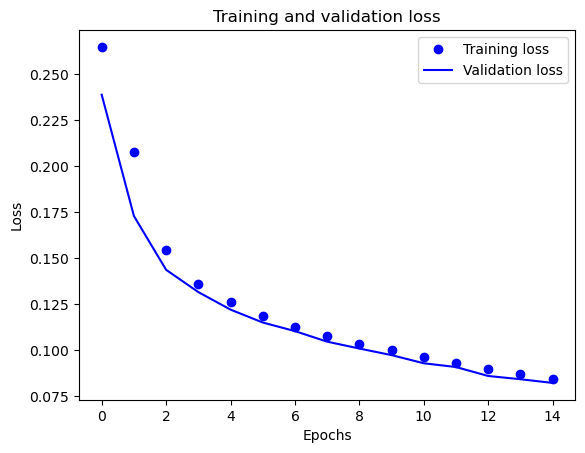

In [186]:
epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

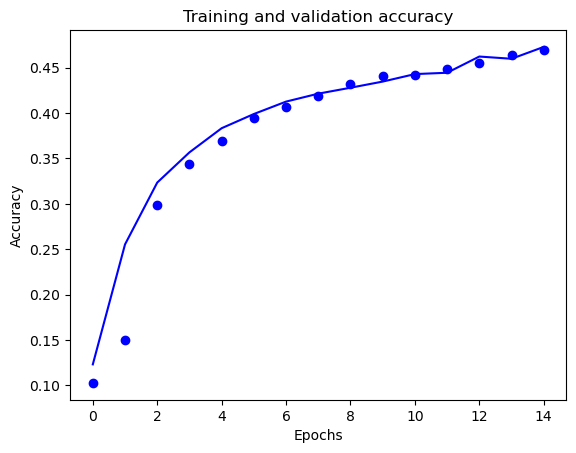

In [187]:
plt.plot(epochs, train_accs, 'bo', label='Training acc')
plt.plot(epochs, val_accs, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [188]:
#function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # print(ys) # Remove the comment to understand the loop
        if next_word == 2:
            break
    return ys


In [189]:
# def greedy_decode(model, src, src_mask, max_len, start_symbol, beam_width, n_best):
#     src = src.to(DEVICE)
#     src_mask = src_mask.to(DEVICE)

#     memory = model.encode(src, src_mask)
#     memory = memory.to(DEVICE)
#     ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
#     sequences = [(ys, 0.0)]
#     results = []

#     for i in range(max_len-1):
#         all_candidates = []
#         for seq, score in sequences:
#             tgt_mask = (generate_square_subsequent_mask(seq.size(0))
#                         .type(torch.bool)).to(DEVICE)
#             out = model.decode(seq, memory, tgt_mask)
#             out = out.transpose(0, 1)
#             prob = model.generator(out[:, -1])
#             log_prob = torch.log_softmax(prob, dim=-1)
#             topk_prob, topk_idx = torch.topk(log_prob, beam_width, dim=-1)
            
#             for k in range(beam_width):
#                 next_word = topk_idx[0, k].item()
#                 candidate_seq = torch.cat([seq, torch.tensor([[next_word]], dtype=torch.long).to(DEVICE)], dim=0)
#                 candidate_score = score + topk_prob[0, k].item()
#                 candidate = (candidate_seq, candidate_score)
#                 all_candidates.append(candidate)
        
#         ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
#         sequences = ordered[:beam_width]

#         n_best_sequences = [(seq[-1], score) for seq, score in sequences[:n_best]]
#         results.append(n_best_sequences)

#         if all(c[0][-1].item() == 2 for c in sequences):
#             break

#     best_sequence = results[0][0][0] if results else []
#     return best_sequence

In [190]:
text2codes(['Go!'], sp)[0].view(-1, 1)

tensor([[ 1],
        [62],
        [ 2]])

In [193]:
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text2codes([src_sentence], sp)[0].view(-1, 1)
    print("SRC: ", src)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX).flatten()
    print("Targ: ", tgt_tokens)
    tgt_chars_specials = codes2text([tgt_tokens])
    tgt_chars = []
    for char in tgt_chars_specials:
        if char != '<s>' and char != '<\s>':
            tgt_chars += [char]
    tgt_chars = ''.join(tgt_chars)
    return tgt_chars


In [194]:
tgt_sent = translate(transformer, 'I drink water every day')
tgt_sent

SRC:  tensor([[1],
        [6],
        [2]])
Targ:  tensor([    1,    18,  1345, 12947,     2])


'▁Jag▁överlevde.</s>'

In [195]:
tgt = translate(transformer, "The house at the end of my street is red")
print(tgt)

SRC:  tensor([[1],
        [5],
        [2]])
Targ:  tensor([    1,   860,  3019, 12947,     2])
▁God▁långsamt.</s>


In [196]:
print(sp.decode_ids([  1,    11,   467, 31921, 31921,     2]))

IndexError: Out of range: piece id is out of range.

In [198]:
eng = ["I live in a big red house.", "The sun is very big and hot.", "Today it's very cold and windy!", "Would you like to have some salt for your pasta?", "You need glasses, beacause you can't see.", "My dog is eigth years old.", "I'm wearing pants and a shirt.", "It is a fire in the building.", "Do you like to study on your computer?", "The bus was very full today."]
cand = []

swe = ["Jag bor i ett stort rött hus.".split(), "Solen är väldigt stor och varm.".split(), "Idag är det väldigt kallt och blåsigt!".split(), "Vill du ha salt till din pasta?".split(), "Du behöver glasögon, för du kan inte se.".split(), "Min hund är är åtta år gammal".split(), "Jag har på mig byxor och en tröja.".split(), "Det är en eld i byggnaden".split(), "Gillar du att plugga på din dator?".split(), "Bussen är väldigt full idag.".split()]

for sent in eng:
    cand.append(translate(transformer, sent).split())
print(cand)
print(bleu_score(cand, swe))

SRC:  tensor([[1],
        [6],
        [2]])
Targ:  tensor([    1,    18,  1345, 12947,     2])
SRC:  tensor([[1],
        [5],
        [2]])
Targ:  tensor([    1,   860,  3019, 12947,     2])
SRC:  tensor([[1],
        [5],
        [2]])
Targ:  tensor([    1,   860,  3019, 12947,     2])
SRC:  tensor([[ 1],
        [63],
        [ 2]])
Targ:  tensor([    1,   860,  3019, 12947,     2])
SRC:  tensor([[  1],
        [141],
        [  2]])
Targ:  tensor([    1,   860,  3019, 12947,     2])
SRC:  tensor([[  1],
        [138],
        [  2]])
Targ:  tensor([    1,   860,  1957, 12947,     2])
SRC:  tensor([[1],
        [6],
        [2]])
Targ:  tensor([    1,    18,  1345, 12947,     2])
SRC:  tensor([[1],
        [6],
        [2]])
Targ:  tensor([    1,    18,  1345, 12947,     2])
SRC:  tensor([[ 1],
        [25],
        [ 2]])
Targ:  tensor([    1,   860,   271, 12947,     2])
SRC:  tensor([[1],
        [5],
        [2]])
Targ:  tensor([    1,   860,  3019, 12947,     2])
[['▁Jag▁över